# Laboratorium 3

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection())
         
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection())

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(callback.add_line)
        return [b_prev, b_next, b_add_point, b_add_line]
    
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(self.callback)
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

In [3]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red', s=1), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.add_scene(Scene([PointsCollection([(2, 1)])], [LinesCollection([[(1,2),(2,3)]])]))

# plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

In [4]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
# plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


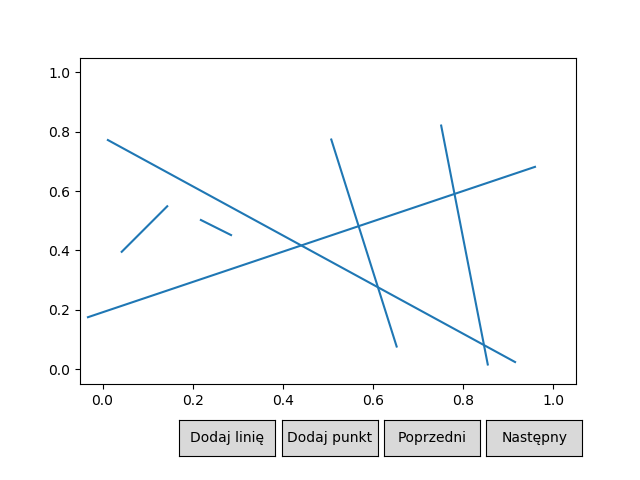

In [5]:
#Dodaj tu punkty i/lub odcinki!
plot1 = Plot()
plot1.draw()

[[(-0.034545110887096775, 0.17400620404411754), (0.9612210181451614, 0.6828910079656862)], [(0.00980972782258066, 0.7738836550245098), (0.9168661794354839, 0.022351792279411642)], [(0.04085811491935487, 0.3930625765931372), (0.14509198588709676, 0.5514571844362746)], [(0.21605972782258065, 0.5042758118872548), (0.2870274697580645, 0.45035424325980394)], [(0.5065839213709677, 0.7772537530637256), (0.6529548891129032, 0.07290326286764698)], [(0.7505355342741936, 0.8244351256127451), (0.8547694052419356, 0.012241498161764619)]] 6


<IPython.core.display.Javascript object>


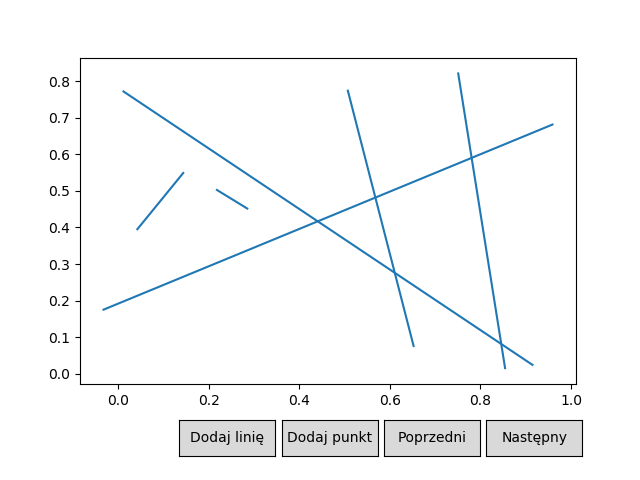

In [6]:
# plot2 = Plot([plot1.get_added_elements()])
# print(len(plot1.get_added_elements()))
# plot2.draw()

for lines_collection in plot1.get_added_elements().lines:
    lines = lines_collection.lines
    
print(lines, len(lines))
Plot([Scene(lines=[LinesCollection(lines)])]).draw()

### Data Generation

In [7]:
%matplotlib notebook
from enum import Enum
from rb_tree import RBTree

In [20]:
def generate_lines(l, r, n, eps=np.float(1e-2)):
    new_lines = []
    while len(new_lines) < n:
        x1, x2 = np.round(np.random.uniform(l, r, size=(2,)), decimals=8)
        y1, y2 = np.round(np.random.uniform(l, r, size=(2,)), decimals=8)
        
        if x1 > x2:
            x1, x2 = x2, x1
        
        if np.abs(x1 - x2) <= eps:
            continue
        
        new_lines.append([(x1,y1), (x2,y2)])
    return new_lines

def lines_to_state_segments(lines):
    segments = []
    for line in lines:
        p1 = Point(line[0][0], line[0][1])
        p2 = Point(line[1][0], line[1][1])
        segments.append(LineSegment(p1, p2))
    return segments

### Rozwiązanie

In [9]:
def determinant(a, b, c):
    return a.x*b.y + a.y*c.x + b.x*c.y - b.y*c.x - a.y*b.x - a.x*c.y

def orient_rel_to_line(point, segment, epsilon=1e-6):
    orientation = determinant(segment.start, segment.end, point)
    
    if orientation < -epsilon:
        return -1
    elif orientation > epsilon:
        return 1
    else:
        return 0

### Data structures

##### Point 

In [10]:
class Point:
    x = 0
    y = 0
    
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __repr__(self):
        return 'Point(%s, %s)' % (self.x, self.y)
    
    def __eq__(self, other):
        return self.y == other.y and self.x == other.x
    
    def __hash__(self):
        return hash((self.x, self.y))

##### Line segment

In [11]:
class LineSegment:
    start = Point(0, 0)
    end = Point(0, 0)
    
    def __init__(self, start, end):
        self.start = start
        self.end = end
    
    def __eq__(self, other):
        return self.start == other.start and self.end == other.end
    
    def __repr__(self):
        return 'Line segment[%s, %s]' % (self.start, self.end)
    
    def __hash__(self):
        return hash((self.start, self.end))

##### Event state

In [12]:
class EventState(Enum):
    start = 1
    intersection = 2
    end = 3
    
    def __lt__(self, other):
        return self.value < other.value

##### Line segment state

In [13]:
class LineSegmentState:
    line_segment = LineSegment(Point(0,0),Point(0,0))
    start = line_segment.start
    end = line_segment.end
    orient_point = line_segment.start
    
    def __init__(self, segment):
        self.line_segment = segment
        self.start = segment.start
        self.end = segment.end
        self.orient_point = segment.start
            
    def __eq__(self, other):
        return self.line_segment == other.line_segment
    
    def __hash__(self):
        return hash(self.line_segment)
        
    def __lt__(self, other):
        orient = None
        if self.orient_point.x >= other.orient_point.x:
            orient = orient_rel_to_line(self.orient_point, other.line_segment)
        else:
            orient = -orient_rel_to_line(other.orient_point, self.line_segment)
        
        return (orient == 1) or \
               (orient == 0 and orient_rel_to_line(self.end, other.line_segment) == 1)

    def __le__(self, other):
        return self < other or self == other

##### Event

In [14]:
class Event:
    point = Point(0,0)
    line_segments = LineSegment(point, point)
    event_type = 1
    
    def __init__(self, point, segments, event_type):
        self.point = point
        self.line_segments = segments
        self.event_type = event_type
        
    def __hash__(self):
        return hash(self.point)
    
    def __eq__(self, other):
        return self.point == other.point and self.event_type == other.event_type
    
    def __lt__(self, other):
        return (self.point.x < other.point.x) or \
               (self.point.x == other.point.x and self.point.y < other.point.y) or \
               (self.point.x == other.point.x and self.point.y == other.point.y and self.event_type < other.event_type)

##### Intersection  

In [15]:
class Intersection(Event):
    def __init__(self, point, segment1, segment2):
        super().__init__(point, (segment1, segment2), EventState.intersection)
        self.segment1 = segment1
        self.segment2 = segment2
        
    def __repr__(self):
        return 'Intersection in %s between %s and %s' % (self.point, self.segment1, self.segment2)
    
    def __hash__(self):
        return hash(self.line_segments)

##### Segment processing & intersection & intersection_check

In [16]:
def segment_processing(segment, curr_state, events, intersections):
    curr_state.insert(segment)
    
    succ = curr_state.successor(segment)
    pred = curr_state.predecessor(segment)
    
    intersection_check(segment, succ, events, intersections)
    intersection_check(segment, pred, events, intersections)
    
def intersection(ls1, ls2, epsilon=1e-6):
    r = ls1.end.x - ls1.start.x, ls1.end.y - ls1.start.y
    s = ls2.end.x - ls2.start.x, ls2.end.y - ls2.start.y
    
    rxs = r[0] * s[1] - r[1] * s[0] 
    
    if rxs > epsilon or rxs < -epsilon:
        q_p = (ls2.start.x - ls1.start.x, ls2.start.y - ls1.start.y)
        t = (q_p[0]*s[1] - q_p[1]*s[0]) / rxs
        u = (q_p[0]*r[1] - q_p[1]*r[0]) / rxs
        
        if((t >= 0. and t<=1.) and (u >= 0. and u <= 1.)):
            return (round(ls1.start.x + t*r[0], 8), round(ls1.start.y + t*r[1], 8))
        else:
            return None
    else:
        return None
    
def intersection_check(ls1, ls2, events, intersections):
    if ls1 is not None and ls2 is not None:
        inter_point = intersection(ls1.line_segment, ls2.line_segment)
        
        if inter_point is not None and inter_point not in intersections:
            intersections.add(inter_point)
            
            event = Intersection(Point(inter_point[0], inter_point[1]), ls1.line_segment, ls2.line_segment)
            events.insert(event)

## Sweeping algorythm

In [17]:
def Sweeping(line_segments):
    events = RBTree()  # Q structure
    curr_state = RBTree()  # T structure
    
    # filling Q structure => starting events
    for segment in line_segments:
        events.insert(Event(segment.start, segment, EventState.start))
        events.insert(Event(segment.end, segment, EventState.end))
        
    intersections = set()
    event = events.minimum()
    
    while event is not None:
        
        if event.event_type == EventState.start:
            segment = LineSegmentState(event.line_segments)  # tworzenie nowej struktury do stany miotly
            segment_processing(segment, curr_state, events, intersections)  # sprawdzanie przeciec z sąsiadami i ewentualne dodanie eventu do struktury Q
            
        elif event.event_type == EventState.end:
            segment = event.line_segments  # pobieranie odcinka z wydarzenia
            state_segment = LineSegmentState(segment)  # tworzenie do szukania sąsiadów
            
            succ = curr_state.successor(state_segment)
            pred = curr_state.predecessor(state_segment)
            
            curr_state.remove(state_segment)
            
            intersection_check(succ, pred, events, intersections)
        else:
            state_segment1 = LineSegmentState(event.segment1)
            state_segment2 = LineSegmentState(event.segment2)
            
            curr_state.remove(state_segment1)
            curr_state.remove(state_segment2)
            
            state_segment1.orient_point = event.point
            state_segment2.orientation_point = event.point
            
            segment_processing(state_segment1, curr_state, events, intersections)
            segment_processing(state_segment2, curr_state, events, intersections)
            
        events.remove(event)
        event = events.minimum()
    
    return intersections

<IPython.core.display.Javascript object>


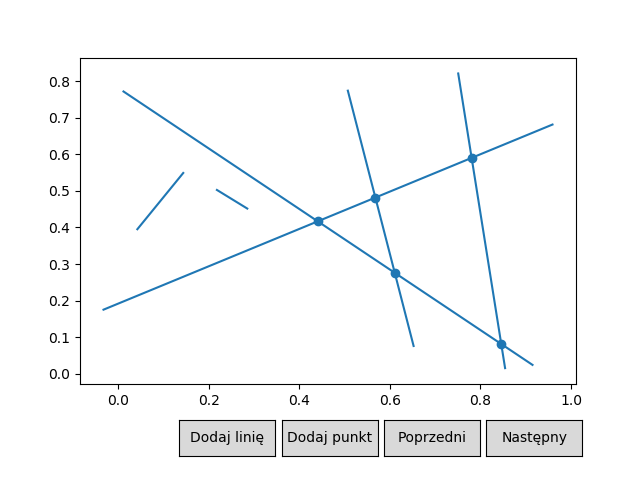

In [21]:
# lines = [[(1, 5), (3, 8)], [(1, 8), (13, 3)], [(1, 2), (14, 6)], [(3, 1), (9, 8)], [(6, 1), (11, 8)]]

line_segments = lines_to_state_segments(lines)
points = Sweeping(line_segments)

goodies = []
for point in points:
    goodies.append(point)

Plot([Scene([PointsCollection(goodies)],[LinesCollection(lines)])]).draw()